# Proyecto Final: Cesar Baute, María Paola Galvis, Luis Gil, Luis Montes, Joyce Wagner

## Jugar a la vieja con una IA

#### **Inicialización de constantes y recompensas**

In [2]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from game_demo import start_game
import random

REWARD_WIN = 20
REWARD_LOSE = -5
REWARD_DRAW = 3
REWARD_BLOCKING = 1.5 
REWARD_DEFAULT = 0
REWARD_CENTER = 0.5

epsilon = 0.90 
epsilon_decay = 0.995
min_epsilon = 0.01 
gamma = 0.8
alpha = 0.1


#### **Funciones de juego**

In [3]:
def check_winner(current_state):
    board = [current_state[i:i+3] for i in range(0, 9, 3)]

    for row in board:
        if row[0] == row[1] == row[2] != " ":
            return row[0]

    for col in range(3):
        if board[0][col] == board[1][col] == board[2][col] != " ":
            return board[0][col]

    if board[0][0] == board[1][1] == board[2][2] != " ":
        return board[0][0]
    if board[0][2] == board[1][1] == board[2][0] != " ":
        return board[0][2]

    if " " in current_state:
        return None  # El juego aún no ha terminado

    return "draw"

def make_move(board, player, action):
    board = board[:action] + player + board[action + 1:]
    return board


#### **Inicialización de Q**

In [4]:
def available_actions(state):
    return [i for i, cell in enumerate(state) if cell == " "]

In [5]:
def initialize_Q():
    Q = {}
    for state in product(" XO", repeat=9):
        if (state.count("X") - state.count("O")) not in (0, 1):
            continue
        string_state = "".join(state)
        for action in available_actions(string_state):
            Q[(string_state, action)] = 0.0
    return Q

Q = initialize_Q()


#### **Funciones de ayuda**

In [6]:
def sample_next_action(current_state, actions, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return random.choice(actions)
    else:
        Qs = np.array([Q.get((current_state, action), 0) for action in actions])
        return actions[np.argmax(Qs)]

def initialize_Q():
    Q = {}
    for state in product(" XO", repeat=9):
        if (state.count("X") - state.count("O")) not in (0, 1):
            continue
        string_state = "".join(state)
        for action in available_actions(string_state):
            Q[(string_state, action)] = 0.0
    return Q

Q = initialize_Q()


def reward_move(current_state, action, player):
    next_state = make_move(current_state, player, action)
    winner = check_winner(next_state)
    if winner == player:
        return REWARD_WIN
    elif winner == "X" if player == "O" else "O":
        return REWARD_LOSE
    elif winner == "draw":
        return REWARD_DRAW
    elif action == 4:
        return REWARD_CENTER
    # Evaluar posibles bloqueos
    blocking_state = make_move(current_state, "X" if player == "O" else "O", action)
    if check_winner(blocking_state) == "X":
        return REWARD_BLOCKING
    return REWARD_DEFAULT


def update(current_state, action, gamma):
    next_state = make_move(current_state, "O", action)
    max_next_Q = np.max([Q.get((next_state, next_action), 0) for next_action in available_actions(current_state)])
    reward = reward_move(current_state, action, "O")
    if check_winner(next_state) is not None:
        gamma = 1.0
    Q[(current_state, action)] = alpha * (reward + gamma * max_next_Q - Q[(current_state, action)])

def save_Q_Matrix(Q):
    with open("Q_matrix.txt", "w") as f:
        for key, value in Q.items():
            f.write(f"{key}: {value}\n")

In [7]:
stat_rates = {
    "wins": [],
    "draws": [],
    "losses": []
}

PARTIDAS_POR_EPISODIO = 100
EPISODES = 10000


## **Entrenamiento**

{'wins': 91, 'draws': 9, 'losses': 0}
{'wins': [0.91], 'draws': [0.09], 'losses': [0.0]}
After 1000 simulations
Win rate: 91.00%
Draw rate: 9.00%
Loss rate: 0.00%

***************

{'wins': 87, 'draws': 9, 'losses': 4}
{'wins': [0.91, 0.87], 'draws': [0.09, 0.09], 'losses': [0.0, 0.04]}
After 2000 simulations
Win rate: 87.00%
Draw rate: 9.00%
Loss rate: 4.00%

***************

{'wins': 90, 'draws': 6, 'losses': 4}
{'wins': [0.91, 0.87, 0.9], 'draws': [0.09, 0.09, 0.06], 'losses': [0.0, 0.04, 0.04]}
After 3000 simulations
Win rate: 90.00%
Draw rate: 6.00%
Loss rate: 4.00%

***************

{'wins': 92, 'draws': 7, 'losses': 1}
{'wins': [0.91, 0.87, 0.9, 0.92], 'draws': [0.09, 0.09, 0.06, 0.07], 'losses': [0.0, 0.04, 0.04, 0.01]}
After 4000 simulations
Win rate: 92.00%
Draw rate: 7.00%
Loss rate: 1.00%

***************

{'wins': 93, 'draws': 6, 'losses': 1}
{'wins': [0.91, 0.87, 0.9, 0.92, 0.93], 'draws': [0.09, 0.09, 0.06, 0.07, 0.06], 'losses': [0.0, 0.04, 0.04, 0.01, 0.01]}
After 5000

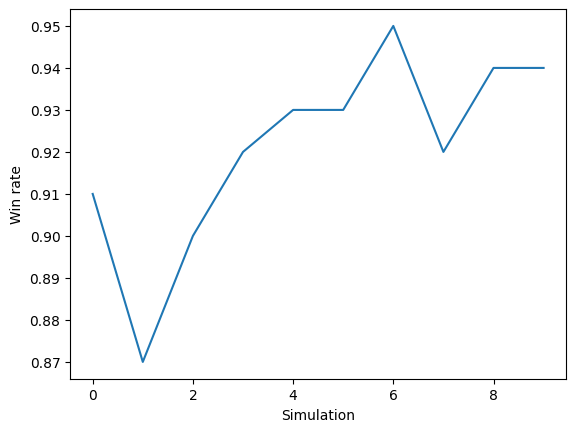

In [8]:
for i in range(EPISODES):
    stats = {
        "wins": 0,
        "draws": 0,
        "losses": 0
    }
    for j in range(PARTIDAS_POR_EPISODIO):
        current_state = " " * 9
        machine_turn = np.random.choice([True, False])
        while True:
            av_actions = available_actions(current_state)
            if len(av_actions) == 0:
                break
            if machine_turn:
                action = sample_next_action(current_state, av_actions, epsilon)
                update(current_state, action, gamma)
                current_state = make_move(current_state, "O", action)
                if check_winner(current_state) == "O":
                    stats["wins"] += 1
                    break
                elif check_winner(current_state) == "draw":
                    stats["draws"] += 1
                    break
            else:
                action = random.choice(av_actions)
                current_state = make_move(current_state, "X", action)
                if check_winner(current_state) == "draw":
                    stats["draws"] += 1
                    break
                elif check_winner(current_state) == "X":
                    stats["losses"] += 1
                    break
            machine_turn = not machine_turn

    if (i + 1) % 1000 == 0:
        stat_rates["wins"].append(stats["wins"] / PARTIDAS_POR_EPISODIO)
        stat_rates["draws"].append(stats["draws"] / PARTIDAS_POR_EPISODIO)
        stat_rates["losses"].append(stats["losses"] / PARTIDAS_POR_EPISODIO)

        print(stats)
        print(stat_rates)
        print("After {} simulations".format(i + 1))
        print("Win rate: {:.2f}%".format(stat_rates["wins"][-1] * 100))
        print("Draw rate: {:.2f}%".format(stat_rates["draws"][-1] * 100))
        print("Loss rate: {:.2f}%".format(stat_rates["losses"][-1] * 100))
        print("\n***************\n")

    epsilon = max(min_epsilon, epsilon * epsilon_decay)

# plt.ion()
plt.plot(stat_rates["wins"])
plt.xlabel("Simulation")
plt.ylabel("Win rate")
plt.show()

# start_game(Q)

#### **Salvar el modelo**

In [9]:
save_Q_Matrix(Q)

#### **Correr**

In [11]:
%run game_demo.py

  X      
1 1
X X O    
0 1
XOX O  X 
1 0
XOXOOX X 
2 2
current_player: O
         
1 1
    O   X
2 1
 X  O  OX
0 0
OXX O  OX
1 2
OXXXOO OX
2 0
current_player: X
  X      
1 1
  X OX   
2 2
X X OX  O
0 1
XOX OX XO
1 0
current_player: X
       X 
1 1
    O  XX
2 0
  X O OXX
1 2
  XXOOOXX
0 0
current_player: X
